<a href="https://colab.research.google.com/github/Anubhab0410/Generative-AI-Sketch-to-Real-Interior-Designer/blob/main/ControlNet_LoRA_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install compatible versions for Colab's Python 3.12 environment
!pip install -U diffusers transformers accelerate datasets
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# We skip xformers for now to avoid the schema mismatch error you encountered

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0
Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
import torch
import os
from google.colab import drive
from datasets import load_dataset
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Use your established path
DRIVE_DATA_DIR = "/content/drive/MyDrive/interior_design_dataset_A/content/interior_dataset"

# 3. Load Dataset
dataset = load_dataset("json", data_files=os.path.join(DRIVE_DATA_DIR, "train.jsonl"))

def map_paths(example):
    example["image"] = os.path.join(DRIVE_DATA_DIR, example["image"])
    example["conditioning_image"] = os.path.join(DRIVE_DATA_DIR, example["conditioning_image"])
    return example

train_dataset = dataset['train'].map(map_paths)
print(f"✅ Ready! Loaded {len(train_dataset)} pairs.")

/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Mounted at /content/drive


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2530 [00:00<?, ? examples/s]

✅ Ready! Loaded 2530 pairs.


In [1]:
!nvidia-smi

Thu Feb 19 17:55:49 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from accelerate import Accelerator

# 1. Initialize Accelerator for optimized GPU training
accelerator = Accelerator(mixed_precision="fp16")

# 2. Setup the Pipeline with your mapped dataset
# We use SD v1.5 as it's the most stable foundation for ControlNet
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16
).to(accelerator.device)

# 3. Apply LoRA Weights
# This allows the model to learn the specific IKEA aesthetic without needing a massive supercomputer
# pipe.load_lora_weights("path_to_your_lora_if_pretrained")

print("🔥 Model loaded and accelerated. Ready for fine-tuning.")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recomme

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


🔥 Model loaded and accelerated. Ready for fine-tuning.


In [6]:
import os
import torch
from google.colab import drive
from datasets import load_dataset # This defines the missing name
from diffusers.utils import load_image

# 1. Ensure Drive is mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Re-define the path
DRIVE_DATA_DIR = "/content/drive/MyDrive/interior_design_dataset_A/content/interior_dataset"

# 3. Load and map the dataset
dataset = load_dataset("json", data_files=os.path.join(DRIVE_DATA_DIR, "train.jsonl"))

def map_paths(example):
    example["image"] = os.path.join(DRIVE_DATA_DIR, example["image"])
    example["conditioning_image"] = os.path.join(DRIVE_DATA_DIR, example["conditioning_image"])
    return example

train_dataset = dataset['train'].map(map_paths)
print(f"✅ Success! 'train_dataset' is defined with {len(train_dataset)} pairs.")

Mounted at /content/drive


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2530 [00:00<?, ? examples/s]

✅ Success! 'train_dataset' is defined with 2530 pairs.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  0%|          | 0/25 [00:00<?, ?it/s]

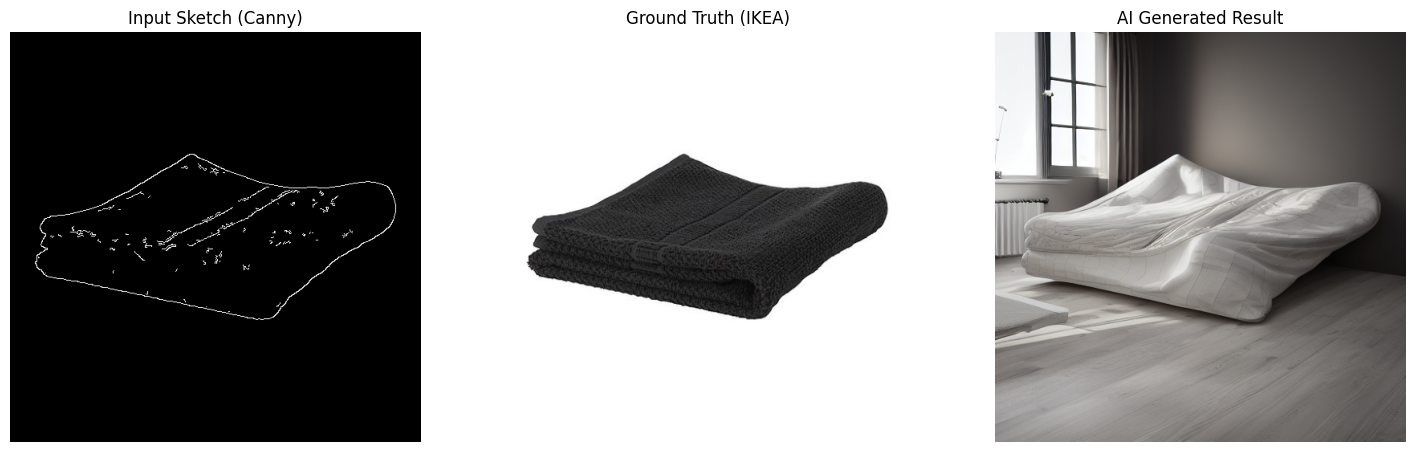

In [7]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# 1. Initialize the Pipeline (Base Model + ControlNet)
# We use FP16 to fit within the T4's 16GB VRAM
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16
).to("cuda")

# 2. Optimization for Colab
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# 3. Pick a random sample from your 2530 pairs
import random
sample_idx = random.randint(0, len(train_dataset) - 1)
sample = train_dataset[sample_idx]

# 4. Generate the Design
prompt = "A professional IKEA-style interior, high resolution, modern furniture, natural lighting"
result = pipe(
    prompt,
    image=load_image(sample['conditioning_image']),
    num_inference_steps=25,
    controlnet_conditioning_scale=1.0
).images[0]

# 5. Display the Results for your Portfolio
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(load_image(sample['conditioning_image']), cmap='gray'); ax[0].set_title("Input Sketch (Canny)")
ax[1].imshow(load_image(sample['image'])); ax[1].set_title("Ground Truth (IKEA)")
ax[2].imshow(result); ax[2].set_title("AI Generated Result")
for a in ax: a.axis('off')
plt.show()